# Install & Import Libraries

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter
from sklearn.utils.class_weight import compute_class_weight

# Parameters

In [4]:
sampling_rate = 20
window_size = 3 * sampling_rate  # 60 timesteps
wand_classes = ["Circle", "Infinity", "None", "Square", "Triangle", "Wave", "Zigzag"]
num_channels_online = 45
num_channels_wand = 6
batch_size = 16
epochs = 30
weight_decay = 1e-4

# Processing Functions

In [6]:
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff=5, fs=50, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    return lfilter(b, a, data)

def normalize_window(window):
    return (window - np.mean(window, axis=0)) / (np.std(window, axis=0) + 1e-8)

def pad_or_crop(sample, window_size):
    n_rows, n_cols = sample.shape
    if n_rows > window_size:
        return sample[:window_size, :]
    elif n_rows < window_size:
        pad_width = ((0, window_size - n_rows), (0, 0))
        return np.pad(sample, pad_width, mode='constant')
    else:
        return sample

# Data cleaning

In [8]:
def clean_data(df):
    """Remove NaNs and reset index."""
    df = df.dropna().reset_index(drop=True)
    return df
    
def clean_dataset(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for fname in os.listdir(input_folder):
        if fname.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_folder, fname))
            df_clean = clean_data(df)
            df_clean.to_csv(os.path.join(output_folder, fname), index=False)
    print(f"Cleaned dataset saved to {output_folder}")

# Dataset loader

In [10]:
def load_preprocess_dataset(dataset_path, window_size=60, use_clean=True,
                            selected_channels=None, class_list=None, use_labels_folder=True):
  
    data_folder = os.path.join(dataset_path, "data_clean" if use_clean else "data")
    X_list, y_list = [], []

    data_files = sorted(os.listdir(data_folder))

    if use_labels_folder:
        label_folder = os.path.join(dataset_path, "label")
        label_files = sorted(os.listdir(label_folder))
        for data_file, label_file in zip(data_files, label_files):
            df = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                df = df[:, selected_channels]
            df_fixed = pad_or_crop(df, window_size)
            X_list.append(df_fixed)

            with open(os.path.join(label_folder, label_file), 'r') as f:
                raw_label = f.read().strip()
            y_list.append(raw_label)
    else:
        for data_file in data_files:
            df = pd.read_csv(os.path.join(data_folder, data_file)).values
            if selected_channels:
                df = df[:, selected_channels]
            df_fixed = pad_or_crop(df, window_size)
            X_list.append(df_fixed)

            # Infer label from filename (e.g. circle_01.csv → "Circle")
            raw_label = os.path.splitext(data_file)[0].split("_")[0].capitalize()
            y_list.append(raw_label)

    X = np.array([StandardScaler().fit_transform(sample) for sample in X_list])
    y = np.array(y_list)

    encoder = LabelEncoder()
    if class_list is None:
        encoder.fit(y)
    else:
        encoder.fit(class_list)
    y_encoded = encoder.transform(y)
    y_onehot = np.eye(len(encoder.classes_))[y_encoded]

    print(f"Loaded {len(X)} samples, {X.shape[1]} timesteps, {X.shape[2]} channels")
    print(f"Classes: {list(encoder.classes_)}")
    return X, y_onehot, encoder

# Train base model on online dataset

In [12]:
dataset_online_path = r"C:\Users\CK Cheong\Desktop\rosbag\data"
X_online, y_online, encoder_online = load_preprocess_dataset(
    dataset_online_path,
    window_size=window_size,
    use_clean=True,
    selected_channels=None,
    class_list=None,
    use_labels_folder=True
)

# Split for training/validation
X_train_online, X_val_online, y_train_online, y_val_online = train_test_split(
    X_online, y_online, test_size=0.2, stratify=y_online, random_state=42
)

Loaded 810 samples, 60 timesteps, 45 channels
Classes: ['label\n0', 'label\n1', 'label\n10', 'label\n2', 'label\n3', 'label\n4', 'label\n5', 'label\n6']


# Base CNN Model

In [14]:
base_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_online)),
    
    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(128, 3, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),
    
    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.4),
    Dense(len(encoder_online.classes_), activation='softmax')
])

base_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

history_online = base_model.fit(
    X_train_online, y_train_online,
    validation_data=(X_val_online, y_val_online),
    epochs=30,
    batch_size=32
)

# Save base model
base_model.save("base_model_online.keras")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 32)         │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,912 (202.78 KB)

 Trainable params: 51,464 (201.03 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.1806 - loss: 2.3025 - val_accuracy: 0.1481 - val_loss: 2.0682
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2284 - loss: 2.0814 - val_accuracy: 0.2716 - val_loss: 2.0254
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2747 - loss: 1.9581 - val_accuracy: 0.3457 - val_loss: 1.9562
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3441 - loss: 1.8341 - val_accuracy: 0.3580 - val_loss: 1.8594
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3858 - loss: 1.7103 - val_accuracy: 0.4012 - val_loss: 1.7257
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4336 - loss: 1.6081 - val_accuracy: 0.4753 - val_loss: 1.5984
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4830 - loss: 1.4599 - val_accuracy: 0.4815 - val_loss: 1.4751
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5448 - loss: 1.3084 - val_accuracy: 0.5247 - v

# Clean wand dataset and load

In [16]:
wand_dataset = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset"
clean_dataset(os.path.join(wand_dataset, "data"),
              os.path.join(wand_dataset, "data_clean"))

X_wand, y_wand, encoder_wand = load_preprocess_dataset(
    wand_dataset,
    window_size=window_size,
    use_clean=True,
    selected_channels=[0,1,2,3,4,5],
    class_list=wand_classes,
    use_labels_folder=False
)

Cleaned dataset saved to C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset\data_clean
Loaded 2734 samples, 60 timesteps, 6 channels
Classes: ['Circle', 'Infinity', 'None', 'Square', 'Triangle', 'Wave', 'Zigzag']


# Compute mean, std

In [18]:
# Make sure all samples are padded/cropped to window_size
X_wand = np.array([StandardScaler().fit_transform(pad_or_crop(sample, window_size))
                   for sample in X_wand])

# Split Training/Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_wand, y_wand, test_size=0.2, stratify=y_wand, random_state=42
)

# Compute mean/std for each channel over all samples and timesteps
channel_mean = X_train.mean(axis=(0, 1))   # shape (num_channels,)
channel_std  = X_train.std(axis=(0, 1))    # shape (num_channels,)

print("Channel means:", channel_mean)
print("Channel stds:", channel_std)

# Save the mean and std values to .npy
np.save("mean_std.npy", {"mean": channel_mean, "std": channel_std})

data = np.load("mean_std.npy", allow_pickle=True).item()
mean = data["mean"]
std  = data["std"]

with open("mean_std.h", "w") as f:
    f.write("#ifndef MEAN_STD_H\n#define MEAN_STD_H\n\n")
    f.write("#include <cstdint>\n\n")

    f.write(f"const float channel_mean[{len(mean)}] = {{")
    f.write(", ".join(f"{m:.8e}" for m in mean))
    f.write("};\n")

    f.write(f"const float channel_std[{len(std)}] = {{")
    f.write(", ".join(f"{s:.8f}" for s in std))
    f.write("};\n\n")

    f.write("#endif // MEAN_STD_H\n")

print("mean_std.h generated successfully.")

Channel means: [ 1.91467361e-18 -2.34617318e-18 -1.51532498e-18  3.18971255e-19
 -5.34721042e-19  1.07536463e-18]
Channel stds: [0.99977135 0.99977135 1.         1.         1.         0.99862732]
mean_std.h generated successfully.


# Apply augmentation

In [20]:
def augment_window_tf(window, label):
    # Ensure window is float32
    window = tf.cast(window, tf.float32)  
    # Gaussian noise
    noise = tf.random.normal(shape=tf.shape(window), mean=0.0, stddev=0.01, dtype=tf.float32)
    # Random scale factor
    scale = tf.random.uniform([], 0.9, 1.1, dtype=tf.float32)
    # Random time shift
    shift = tf.random.uniform([], -3, 3, dtype=tf.int32)
    # Apply augmentations
    window = window + noise
    window = window * scale
    window = tf.roll(window, shift=shift, axis=0)
    
    return window, label

def make_dataset(X, y, batch_size=32, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True)
        ds = ds.map(augment_window_tf, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train, batch_size=16, training=True)
val_ds   = make_dataset(X_val, y_val, batch_size=16, training=False)

# Compute Class Weights (for balancing) 
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Define Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "cnn_finetuned_wand_best.keras", monitor='val_accuracy',
    save_best_only=True, verbose=1
)

Class Weights: {0: 0.9583698510078879, 1: 0.9732977303070761, 2: 1.2700348432055748, 3: 0.9702750665483585, 4: 0.9702750665483585, 5: 0.9613186813186814, 6: 0.9613186813186814}


# Fine-tune model for wand dataset

In [22]:
finetune_model = Sequential([
    tf.keras.Input(shape=(window_size, num_channels_wand)),

    Conv1D(32, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 5, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    Dropout(0.4),
    Dense(len(encoder_wand.classes_), activation='softmax')
])

finetune_model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

finetune_model.summary()

# Train Model 
history_finetune = finetune_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Save Final Model 
finetune_model.save("cnn_finetuned_wand_augmented.keras")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 56, 32)         │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,295 (63.65 KB)

 Trainable params: 16,103 (62.90 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1408 - loss: 2.0916
Epoch 1: val_accuracy improved from None to 0.20293, saving model to cnn_finetuned_wand_best.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1578 - loss: 2.0502 - val_accuracy: 0.2029 - val_loss: 1.9331
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2258 - loss: 1.8642
Epoch 2: val_accuracy improved from 0.20293 to 0.43510, saving model to cnn_finetuned_wand_best.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.2487 - loss: 1.8411 - val_accuracy: 0.4351 - val_loss: 1.7751
Epoch 3/50
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3451 - loss: 1.7079
Epoch 3: val_accuracy improved from 0.43510 to 0.65448, saving model to cnn_finetuned_wand_best.keras
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3516 - loss: 1.7010 - val_accuracy: 0.6545 - val_loss: 1.5916
Epoch 4/50
135/137 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4192 - loss: 1.

# Evaluate fine-tuned model

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

      Circle       0.96      0.94      0.95       407
    Infinity       0.97      0.98      0.98       401
        None       0.97      0.95      0.96       307
      Square       0.98      0.96      0.97       403
    Triangle       0.94      0.98      0.96       403
        Wave       0.96      0.99      0.97       406
      Zigzag       0.99      0.98      0.98       407

    accuracy                           0.97      2734
   macro avg       0.97      0.97      0.97      2734
weighted avg       0.97      0.97      0.97      2734



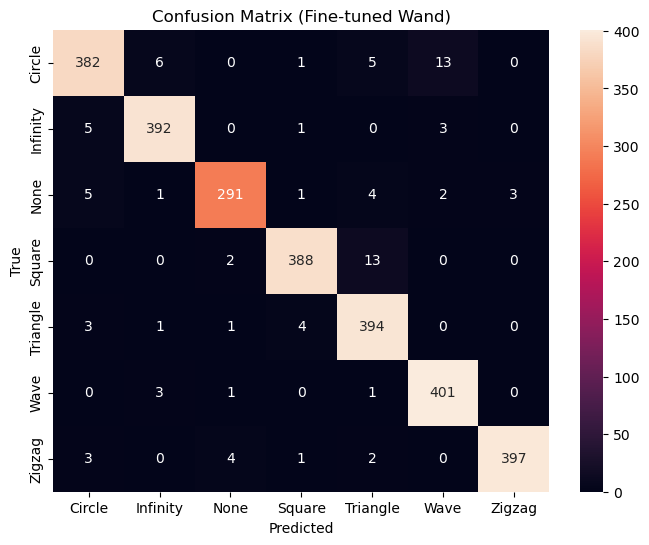

In [24]:
y_pred = finetune_model.predict(X_wand)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_wand, axis=1)

print(classification_report(
    y_true_classes, y_pred_classes,
    target_names=wand_classes,
    zero_division=0
))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=wand_classes, yticklabels=wand_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Fine-tuned Wand)')
plt.show()


# Generate test data and Extract Weights, Biases

In [47]:
# Load your trained model
model = tf.keras.models.load_model("cnn_finetuned_wand_augmented.keras")

# Parameters
num_samples = 10
window_size = 60
num_channels_wand = 6
num_classes = 7
clean_dir = r"C:\Users\CK Cheong\Documents\GitHub\CG4002-Wizard-Game-Project\AI\wand_dataset\data_clean"

# Load and preprocess test windows
def load_test_windows(num_samples=num_samples):
    files = sorted(glob.glob(os.path.join(clean_dir, "*.csv")))
    X, labels = [], []
    class_names = []

    for f in files[:num_samples]:
        df = pd.read_csv(f)
        arr = df.values.astype(np.float32)
        # Take last num_channels if CSV has extra
        if arr.shape[1] != num_channels_wand:
            if arr.shape[1] > num_channels_wand:
                arr = arr[:, -num_channels_wand:]
            else:
                print("Skipping (wrong #cols):", f)
                continue
        # Pad or crop
        if arr.shape[0] > window_size:
            arr = arr[:window_size, :]
        elif arr.shape[0] < window_size:
            pad = np.zeros((window_size - arr.shape[0], arr.shape[1]), dtype=np.float32)
            arr = np.vstack([arr, pad])
            
        arr = StandardScaler().fit_transform(arr)
        # arr = (arr - channel_mean) / channel_std


        X.append(arr)
        # Infer label from filename
        label = os.path.basename(f).split("_")[0].capitalize()
        labels.append(label)
        if label not in class_names:
            class_names.append(label)

    if len(X) == 0:
        return None, None, None

    X = np.stack(X, axis=0)
    return X, labels, class_names

x_test, y_labels, class_names = load_test_windows(num_samples)

# 2. Predict
y_pred = model.predict(x_test, verbose=0)
pred_classes = np.argmax(y_pred, axis=1)

print("Predicted classes:", pred_classes)
print("True labels:", y_labels)

# 3. Quantization
def quantize_q8_8(x):
    return np.round(x * 256).astype(np.int16)

x_q = quantize_q8_8(x_test)       # Q8.8 input
y_q = quantize_q8_8(y_pred)       # Q8.8 output

# Write test_data.h
with open("test_data.h", "w") as f:
    f.write("/* Test dataset from Keras CNN */\n")
    f.write("#ifndef TEST_DATA_H\n#define TEST_DATA_H\n\n")
    f.write("#include <cstdint>\n\n")
    f.write(f"#define NUM_SAMPLES {x_q.shape[0]}\n")
    f.write(f"#define INPUT_LEN {window_size}\n")
    f.write(f"#define INPUT_CH {num_channels_wand}\n")
    f.write(f"#define NUM_CLASSES {num_classes}\n\n")

    # Input array
    f.write(f"const int16_t test_inputs[NUM_SAMPLES][INPUT_LEN][INPUT_CH] = {{\n")
    for n in range(x_q.shape[0]):
        f.write("  {\n")
        for t in range(window_size):
            row = ", ".join(map(str, x_q[n, t]))
            f.write(f"    {{{row}}},\n")
        f.write("  },\n")
    f.write("};\n\n")

    # Output array
    f.write(f"const int16_t test_outputs[NUM_SAMPLES][NUM_CLASSES] = {{\n")
    for n in range(x_q.shape[0]):
        row = ", ".join(map(str, y_q[n]))
        f.write(f"  {{{row}}},\n")
    f.write("};\n\n")
    f.write("#endif // TEST_DATA_H\n")

# Export weights
def quantize_bias(b):
    return np.round(b * (256 * 256)).astype(np.int32)

with open("cnn_weights.h", "w") as f:
    f.write("// CNN weights (Q8.8 fixed-point)\n\n")
    f.write("#include <cstdint>\n\n")
    for layer in model.layers:
        weights = layer.get_weights()
        if not weights:
            continue
        f.write(f"// Layer: {layer.name}\n")
        for i, w in enumerate(weights):
            if len(w.shape) == 3:  # Conv1D
                w = np.transpose(w, (2, 1, 0))  # (out, in, k)
                q = quantize_q8_8(w)
            elif len(w.shape) == 2:  # Dense
                q = quantize_q8_8(w)
            elif len(w.shape) == 1:  # Bias
                q = quantize_bias(w)
            else:
                continue
            flat = q.flatten()
            dtype = "int32_t" if len(w.shape) == 1 else "int16_t"
            name = f"{layer.name}_param{i}"
            f.write(f"const {dtype} {name}[{len(flat)}] = {{\n")
            f.write(", ".join(map(str, flat)))
            f.write("\n};\n\n")
    f.write("// End of cnn_weights.h\n")

print("Test data and weights exported.")

Predicted classes: [0 0 0 0 0 0 0 0 0 0]
True labels: ['Circle', 'Circle', 'Circle', 'Circle', 'Circle', 'Circle', 'Circle', 'Circle', 'Circle', 'Circle']
Test data and weights exported.
